### 學號:0624025

### 姓名:黃樂昀

### 學號:0624037

### 姓名:沈孟澤

# 花卉種類辨識

# 故事介紹
    可以用於APP裡面來辨識是哪種花，人在戶外，看到好看的花，但不知道是什麼，打開APP，就可以知道了。

# 資料集介紹
    分成：菊花、太陽花、鬱金香、玫瑰、(蒲公英)
    Train：3235
    Valid：360

In [1]:
import os
import tensorflow.keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras import models
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50
import numpy as np
import pandas as pd
from keras.preprocessing import image

In [2]:
BASE_PATH = "./Flowers"
# derive the training, validation, and testing directories
train_path = os.path.join(BASE_PATH, "train")
valid_path = os.path.join(BASE_PATH, "validation")
test_path = os.path.join(BASE_PATH, "test")

In [3]:
IMG_WIDTH = 300
IMG_HEIGHT = 300
BATCH_SIZE = 8

In [4]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    featurewise_center=True,
    #featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    #validation_split=0.1, # 定義validation的比例
)

In [5]:
train_flow = datagen.flow_from_directory(train_path, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True) #subset='training'  # training subset  )
valid_flow = datagen.flow_from_directory(valid_path, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True) #subset='validation'  #validation subset )

Found 3226 images belonging to 4 classes.
Found 360 images belonging to 4 classes.


In [6]:
flow = datagen.flow_from_directory(train_path, 
       batch_size=1,
       target_size=(IMG_HEIGHT, IMG_WIDTH), 
       shuffle=True)

Found 3226 images belonging to 4 classes.


c:\users\robbie\anaconda3\envs\ai20\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


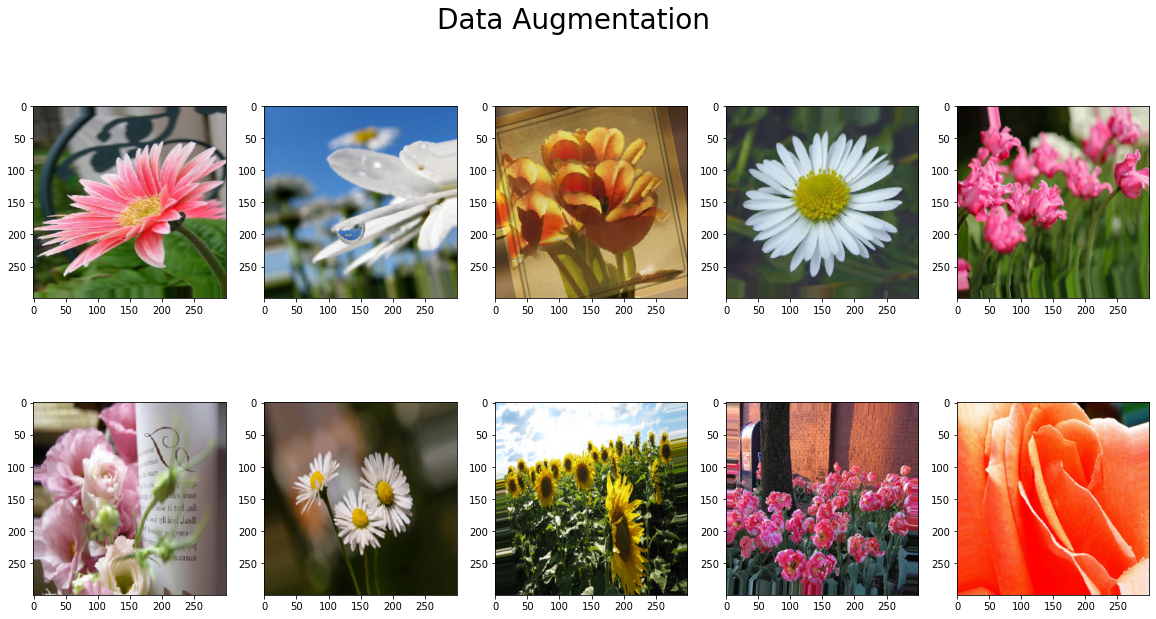

In [7]:
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for img_info in flow:
    x = img_info[0] # 圖片的array在第0個 (1,xx,xx,3)
    # print(x.shape)
    x = x.reshape((IMG_HEIGHT,  IMG_WIDTH, 3) ) # shape is (299,299,3)
    # x = x /255. # 不能再scale一次!! # 繪圖0~1 float32  0~255 需為int  
    
    plt.subplot(2, 5, i+1)
    plt.grid(False)
    plt.imshow( x )
    
    if i == 9:
        break
    i += 1
    
plt.show()

# CNN

In [6]:
input_shape=(IMG_HEIGHT, IMG_WIDTH,3)

model = models.Sequential()
model.add(Conv2D(64, (3, 3), input_shape=input_shape, strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 300, 300, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      18464     
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 16)        4

In [9]:
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-6, momentum=0.9),
              #learning_rate=0.001, rho=0.95, epsilon=1e-07,
              #SGD(lr=1e-6, momentum=0.9)
              metrics=['acc'])

In [10]:
# checkpoint
checkpoint_filepath = './best_cnn_model0.h5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_loss',
    mode='min',
    
    #monitor='val_accuracy',
    #mode='max',
    save_best_only=True,
    period=1
)

In [11]:
# 搭配EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1),
# patience=5 表示連續5次沒有改善就停止訓練

In [12]:
history = model.fit(
    train_flow, # 一次讀入一批訓練
    validation_data=valid_flow, # 一次讀入一批validate
    epochs=50,
    verbose=1,
    #steps_per_epoch=training_data_n/BATCH_SIZE,
    #validation_steps=validation_data_n/BATCH_SIZE,
    #max_queue_size=10, # default value is 10 # CPU會先讀入10批進入RAM，以便GPU不必等待CPU
    callbacks=[checkpoint, early_stopping]
)

model.save('./best_cnn_Flowers.h5')

c:\users\robbie\anaconda3\envs\ai20\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
405/405 [==============================] - 68s 169ms/step - loss: 1.8295 - acc: 0.3172 - val_loss: 1.3132 - val_acc: 0.3833
Epoch 2/50
405/405 [==============================] - 67s 166ms/step - loss: 1.6222 - acc: 0.3638 - val_loss: 1.3777 - val_acc: 0.4333
Epoch 3/50
405/405 [==============================] - 68s 167ms/step - loss: 1.5079 - acc: 0.4294 - val_loss: 1.2489 - val_acc: 0.5056
Epoch 4/50
405/405 [==============================] - 66s 163ms/step - loss: 1.4448 - acc: 0.4430 - val_loss: 1.2514 - val_acc: 0.4972
Epoch 5/50
405/405 [==============================] - 66s 163ms/step - loss: 1.4220 - acc: 0.4624 - val_loss: 1.2324 - val_acc: 0.5083
Epoch 6/50
405/405 [==============================] - 66s 163ms/step - loss: 1.4124 - acc: 0.4454 - val_loss: 1.1571 - val_acc: 0.5167
Epoch 7/50
405/405 [==============================] - 66s 163ms/step - loss: 1.4057 - acc: 0.4634 - val_loss: 1.2396 - val_acc: 0.5194
Epoch 8/50
405/405 [==============================] - 6

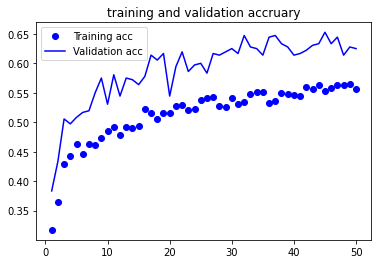

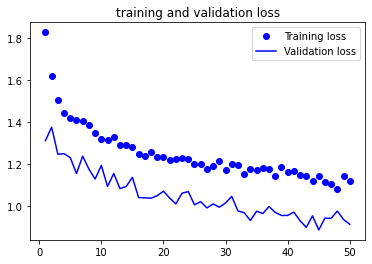

In [13]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('training and validation accruary')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

# ResNet

In [14]:
model2 = ResNet50(weights='imagenet', include_top=False,  input_tensor=None, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
for layer in model2.layers[29:143]:
    layer.trainable = False
    
for layer in model2.layers[144:]:
    layer.trainable = True

In [15]:
img_file = 'D:/AI/Flowers/train/daisy/image_06223.jpg'
img = image.load_img(img_file, target_size=(IMG_HEIGHT, IMG_WIDTH)) #  (img_height, img_width)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x = model2.output
x = Flatten()(x)
# 增加 DropOut layer
x = Dropout(0.5)(x)
# 增加 Dense layer，以 softmax 產生個類別的機率值
predictions = Dense(4, activation='softmax')(x)

model3 = Model(inputs=model2.input, outputs=predictions)

In [16]:
from keras.optimizers import Adadelta
model3.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(lr=0.001, rho=0.95, epsilon=1e-07),
              #learning_rate=0.001, rho=0.95, epsilon=1e-07,
              #SGD(lr=1e-6, momentum=0.9)
              metrics=['acc'])

In [17]:
# checkpoint
checkpoint_filepath = 'D:/AI/best_res_Flowercheck_decay1e-6.h5'
checkpoint2 = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_loss',
    mode='min',
    #monitor='val_accuracy',
    #mode='max',
    save_best_only=True,
    period=1
)

# 搭配EarlyStopping
early_stopping2 = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

In [18]:
history2 = model3.fit(
    train_flow, # 一次讀入一批訓練
    validation_data=valid_flow, # 一次讀入一批validate
    epochs=50,
    verbose=1,
    #steps_per_epoch=training_data_n/BATCH_SIZE,
    #validation_steps=validation_data_n/BATCH_SIZE,
    #max_queue_size=10, # default value is 10 # CPU會先讀入10批進入RAM，以便GPU不必等待CPU
    callbacks=[checkpoint2, early_stopping2]
)

model3.save('./best_res_Flowers_1e-7.h5')

Epoch 1/50
405/405 [==============================] - 77s 191ms/step - loss: 2.6968 - acc: 0.3366 - val_loss: 2.0743 - val_acc: 0.2833
Epoch 2/50
405/405 [==============================] - 72s 178ms/step - loss: 2.2201 - acc: 0.4139 - val_loss: 1.4968 - val_acc: 0.4944
Epoch 3/50
405/405 [==============================] - 72s 178ms/step - loss: 1.9205 - acc: 0.4819 - val_loss: 0.8814 - val_acc: 0.6667
Epoch 4/50
405/405 [==============================] - 89s 219ms/step - loss: 1.7329 - acc: 0.5289 - val_loss: 0.8291 - val_acc: 0.7250
Epoch 5/50
405/405 [==============================] - 72s 179ms/step - loss: 1.5749 - acc: 0.5672 - val_loss: 0.7853 - val_acc: 0.7333
Epoch 6/50
405/405 [==============================] - 74s 184ms/step - loss: 1.4109 - acc: 0.6108 - val_loss: 0.6241 - val_acc: 0.7722
Epoch 7/50
405/405 [==============================] - 73s 181ms/step - loss: 1.2909 - acc: 0.6303 - val_loss: 0.5543 - val_acc: 0.7889
Epoch 8/50
405/405 [==============================] - 7

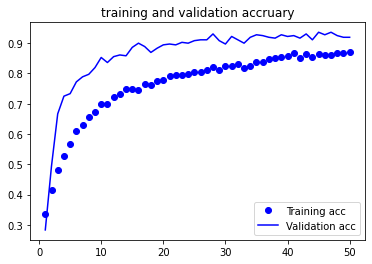

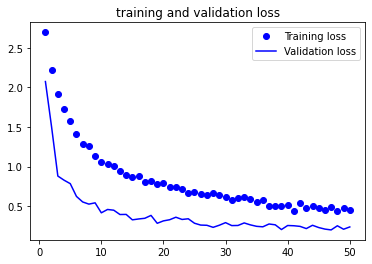

In [19]:
acc=history2.history['acc']
val_acc=history2.history['val_acc']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('training and validation accruary')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()


# 準確度

## CNN

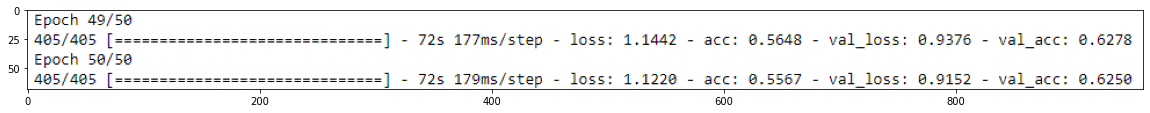

In [105]:
imgc_path = './Flowers/cnn.png'
imc = cv2.imread(imgc_path,1)	# load image as bgr
imc2 = imc[:,:,::-1] 	# transform image to rgb
imc
plt.figure(figsize=(20,800))
plt.imshow(imc2)
plt.show()

## Res

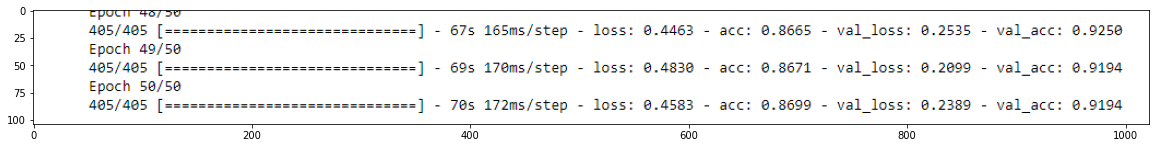

In [110]:
imgr_path = './Flowers/res.png'
imr = cv2.imread(imgr_path,1)	# load image as bgr
imr2 = imr[:,:,::-1] 	# transform image to rgb

plt.figure(figsize=(20,800))
plt.imshow(imr2)
plt.show()

# Predict 

In [8]:
from keras.models import load_model

In [9]:
img_path = './Flowers/test/6.jpg'

In [10]:
img = image.load_img(img_path,target_size=(300, 300))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
# img_tensor = preprocess_input(x)

(1, 300, 300, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

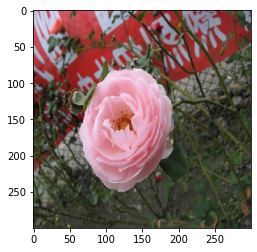

In [11]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show

In [12]:
model2 = load_model('./best_cnn_model0.h5')
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 300, 300, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      18464     
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 16)        4

In [13]:
preds2 = model2.predict(img_tensor)

In [14]:
class_name=['daisy','rose','sunflower','tulip']
# np.argmax(preds[0])
print(class_name[np.argmax(preds2)])

rose


In [15]:
model = load_model('./best_res_Flowers_1e-7.h5')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [16]:
preds = model.predict(img_tensor)

In [17]:
class_name=['daisy','rose','sunflower','tulip']
# np.argmax(preds[0])
print(class_name[np.argmax(preds)])

rose


In [38]:
from keras.applications.imagenet_utils import decode_predictions
import tensorflow as tf
from keras import backend as K
import cv2


In [ ]:
img_path = './ok773569.jpg'
img2 = image.load_img(img_path, target_size=(300, 300))

In [89]:
def gradCAM(orig, intensity=0.5, res=250):
  img = image.load_img(orig, target_size=(300, 300))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  #print(decode_predictions(preds)[0][0][1]) # prints the class of image

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv5_block3_out')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((10, 10))

  img = cv2.imread(orig)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  img2 =  cv2.resize(cv2.imread(orig), (res, res))
#   im = cv2.imread(img,1)	# load image as bgr
#   im2 = im[:,:,::-1] 	# transform image to rgb
  im2 = img2[:,:,::-1] 
  plt.imshow(img2)
  plt.show()

  img3 =  cv2.resize(img, (res, res))
  im3 = img3[:,:,::-1]  
  plt.imshow(im3)
  plt.show()  
#   cv2.imshow('test',img2)
#   cv2.imshow('test2',img3)
#   cv2.waitKey(0)
#   cv2.destroyAllWindows()

c:\users\robbie\anaconda3\envs\ai20\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


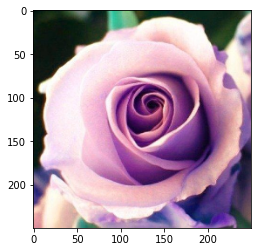

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


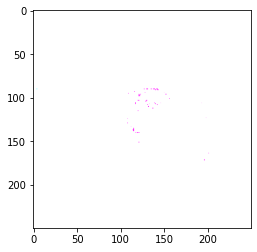

In [90]:
gradCAM(img_path)

# 參考資料

[dataset](https://www.kaggle.com/dwaraka9966/flowers)

[optimizer](https://blog.csdn.net/u012759136/article/details/52302426?utm_medium=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param)

[optimizer_keras](https://keras.io/zh/optimizers/)

[heatmap](https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759)

[cvs_imshow](https://blog.csdn.net/kuweicai/article/details/103359299)

In [ ]:
!nvidia-smi

Mon Jan  4 14:16:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install PyYAML==5.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/AI_Final/Yolo

/content/drive/MyDrive/AI_Final/Yolo


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import shutil
from pathlib import Path
import numpy as np
from matplotlib import pyplot
import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

from PIL import Image

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import (
    check_img_size, non_max_suppression, apply_classifier, scale_coords,
    xyxy2xywh, plot_one_box, strip_optimizer, set_logging)
from utils.torch_utils import select_device, load_classifier, time_synchronized



from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img

from utils.datasets import letterbox as original_size_to_letterbox

In [ ]:
%%time
!python train.py --img 416 --batch 32 --epochs 200 --data ./train_info/data.yaml --cfg ./train_info/custom_yolov5m.yaml --weights ./weights/yolov5m.pt --name yolov5m_results --cache

./train_info/data.yaml
./train_info/custom_yolov5m.yaml
data/hyp.scratch.yaml
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Namespace(adam=False, batch_size=32, bucket='', cache_images=True, cfg='./train_info/custom_yolov5m.yaml', data='./train_info/data.yaml', device='', epochs=200, evolve=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], local_rank=-1, logdir='runs/', multi_scale=False, name='yolov5m_results', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=32, weights='./weights/yolov5m.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
2021-01-04 14:24:51.360846: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warm